In [ ]:
#from __future__ import print_function
#import keras
#from keras.datasets import cifar10
#from keras.preprocessing.image import ImageDataGenerator
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D
import os
#import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
#import torch
#from transformers import SegformerModel, SegformerConfig
#import seaborn as sns
#import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools


#%matplotlib inline

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

##Load Images
- Load and save images in an npy
- 350 images

In [ ]:
directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/google_dark_light_decal_dawn_clear/rgb'

# List to store image arrays
images = []

# Iterate through each PNG file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        images.append(img_array)

# Convert list of arrays into a single NumPy array
image_array = np.array(images)

np.save('/content/drive/MyDrive/Black-Box_CNN/Data/google_dark_light_decal_dawn_clear_images.npy', image_array)

NameError: name 'os' is not defined

##Labels
  - Labels are in json file on drive

In [ ]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

#Truth
# Color map for ground truth images from CARLA
color_map_carla = [
    #       name                     id    trainId   category            catId        hasInstances          ignoreInEval        color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 255       ,  (  0,   0,   0)        , True         , (  0,  0,  0) ),# False (  0,   0,   0) ),
    Label(  'building'             , 11 ,        2 , 'construction'    ,   1       ,  ( 70,  70,  70)        , False        , (  1,  0,  0) ),# False ( 70,  70,  70) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    ,   1       ,  ( 40,  40, 100)        , False        , (  2,  0,  0) ),# False (100,  40,  40) ),
    Label(  'other'                , 37 ,      255 , 'void'            , 255       ,  ( 80,  90,  55)        , True         , (  3,  0,  0) ),# False ( 55,  90,  80) ),
    Label(  'pedestrian'           , 24 ,       11 , 'human'           ,   5       ,  ( 60,  20, 220)        , False        , (  4,  0,  0) ),# True  (220,  20,  60) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          ,   2       ,  (153, 153, 153)        , False        , (  5,  0,  0) ),# False (153, 153, 153) ),
    Label(  'roadline'             , 34 ,        0 , 'flat'            ,   0       ,  ( 50, 234, 157)        , False        , (  6,  0,  0) ),# False (157, 234,  50) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            ,   0       ,  (128,  64, 128)        , False        , (  7,  0,  0) ),# False (128,  64, 128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            ,   0       ,  (232,  35, 244)        , False        , (  8,  0,  0) ),# False (244,  35, 232) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          ,   3       ,  ( 35, 142, 107)        , False        , (  9,  0,  0) ),# False (107, 142,  35) ),
    Label(  'vehicles'             , 35 ,       12 , 'vehicle'         ,   6       ,  (142,   0,   0)        , False        , ( 10,  0,  0) ),# True  (  0,   0, 142) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    ,   1       ,  (156, 102, 102)        , False        , ( 11,  0,  0) ),# False (102, 102, 156) ),
    Label(  'trafficsign'          , 20 ,        7 , 'object'          ,   2       ,  (  0, 220, 220)        , False        , ( 12,  0,  0) ),# False (220, 220,   0) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             ,   4       ,  (180, 130,  70)        , False        , ( 13,  0,  0) ),# False ( 70, 130, 180) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 255       ,  ( 81,   0,  81)        , True         , ( 14,  0,  0) ),# False ( 81,   0,  81) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 255       ,  (100, 100, 150)        , True         , ( 15,  0,  0) ),# False (150, 100, 100) ),
    Label(  'railtrack'            , 10 ,      255 , 'flat'            , 255       ,  (140, 150, 230)        , True         , ( 16,  0,  0) ),# False (230, 150, 140) ),
    Label(  'guardrail'            , 14 ,      255 , 'construction'    , 255       ,  (180, 165, 180)        , True         , ( 17,  0,  0) ),# False (180, 165, 180) ),
    Label(  'trafficlight'         , 19 ,        6 , 'object'          ,   2       ,  ( 30, 170, 250)        , False        , ( 18,  0,  0) ),# False (250, 170,  30) ),
    Label(  'static'               ,  4 ,        4 , 'construction'    ,   1       ,  (160, 190, 110)        , False        , ( 19,  0,  0) ),# False (110, 190, 160) ), # every instance in our map can be considered fence
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 255       ,  ( 50, 120, 170)        , True         , ( 20,  0,  0) ),# False (170, 120,  50) ),
    Label(  'water'                , 36 ,      255 , 'nature'          , 255       ,  (150,  60,  45)        , True         , ( 21,  0,  0) ),# False ( 45,  60, 150) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          ,   3       ,  (100, 170, 145)        , False        , ( 22,  0,  0) ),# False (145, 170, 100) ),
]

color_map_carla_modified = [
    #       name                     id    trainId   category            catId        hasInstances          ignoreInEval        color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 255       ,  (  0,   0,   0)        , True         , (  0,  0,  0) ),# False (  0,   0,   0) ),
    Label(  'building'             , 11 ,        2 , 'construction'    ,   1       ,  ( 70,  70,  70)        , False        , (  1,  0,  0) ),# False ( 70,  70,  70) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    ,   1       ,  ( 40,  40, 100)        , False        , (  2,  0,  0) ),# False (100,  40,  40) ),
    Label(  'other'                , 37 ,      255 , 'void'            , 255       ,  ( 80,  90,  55)        , True         , (  3,  0,  0) ),# False ( 55,  90,  80) ),
    Label(  'pedestrian'           , 24 ,       11 , 'human'           ,   5       ,  ( 60,  20, 220)        , False        , (  4,  0,  0) ),# True  (220,  20,  60) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          ,   2       ,  (153, 153, 153)        , False        , (  5,  0,  0) ),# False (153, 153, 153) ),
    Label(  'roadline'             , 34 ,        0 , 'flat'            ,   0       ,  ( 50, 234, 157)        , False        , (  6,  0,  0) ),# False (157, 234,  50) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            ,   0       ,  (128,  64, 128)        , False        , (  7,  0,  0) ),# False (128,  64, 128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            ,   0       ,  (232,  35, 244)        , False        , (  8,  0,  0) ),# False (244,  35, 232) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          ,   3       ,  ( 35, 142, 107)        , False        , (  9,  0,  0) ),# False (107, 142,  35) ),
    Label(  'vehicles'             , 35 ,       12 , 'vehicle'         ,   6       ,  (142,   0,   0)        , False        , ( 10,  0,  0) ),# True  (  0,   0, 142) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    ,   1       ,  (156, 102, 102)        , False        , ( 11,  0,  0) ),# False (102, 102, 156) ),
    Label(  'trafficsign'          , 20 ,        7 , 'object'          ,   2       ,  (  0, 220, 220)        , False        , ( 12,  0,  0) ),# False (220, 220,   0) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             ,   4       ,  (180, 130,  70)        , False        , ( 13,  0,  0) ),# False ( 70, 130, 180) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 255       ,  ( 81,   0,  81)        , True         , ( 14,  0,  0) ),# False ( 81,   0,  81) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 255       ,  (100, 100, 150)        , True         , ( 15,  0,  0) ),# False (150, 100, 100) ),
    Label(  'railtrack'            , 10 ,      255 , 'flat'            , 255       ,  (140, 150, 230)        , True         , ( 16,  0,  0) ),# False (230, 150, 140) ),
    Label(  'guardrail'            , 14 ,      255 , 'construction'    , 255       ,  (180, 165, 180)        , True         , ( 17,  0,  0) ),# False (180, 165, 180) ),
    Label(  'trafficlight'         , 19 ,        6 , 'object'          ,   2       ,  ( 30, 170, 250)        , False        , ( 18,  0,  0) ),# False (250, 170,  30) ),
    Label(  'static'               ,  4 ,        4 , 'construction'    ,   1       ,  (160, 190, 110)        , False        , ( 19,  0,  0) ),# False (110, 190, 160) ), # every instance in our map can be considered fence
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 255       ,  ( 50, 120, 170)        , True         , ( 20,  0,  0) ),# False (170, 120,  50) ),
    Label(  'water'                , 36 ,      255 , 'nature'          , 255       ,  (150,  60,  45)        , True         , ( 21,  0,  0) ),# False ( 45,  60, 150) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          ,   3       ,  (100, 170, 145)        , False        , ( 22,  0,  0) ),# False (145, 170, 100) ),
]


#Prediction
# Color map for predicted images using cityscapes colors
color_map_cityscapes = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 255       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 255       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 255       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 255       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 255       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 255       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 255       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            ,   0       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            ,   0       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 255       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 255       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    ,   1       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    ,   1       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    ,   1       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 255       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 255       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 255       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          ,   2       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,        5 , 'object'          ,   2       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          ,   2       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          ,   2       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          ,   3       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          ,   3       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             ,   4       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           ,   5       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       11 , 'human'           ,   5       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       12 , 'vehicle'         ,   6       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       12 , 'vehicle'         ,   6       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       12 , 'vehicle'         ,   6       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,       12 , 'vehicle'         ,   6       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,       12 , 'vehicle'         ,   6       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       12 , 'vehicle'         ,   6       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       12 , 'vehicle'         ,   6       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       12 , 'vehicle'         ,   6       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       12 , 'vehicle'         ,   6       , False        , True         , (  0,  0,142) ),
]


color_map_carla_simplified = [
    #       name                     id    trainId   category            catId        hasInstances          ignoreInEval        color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 255       ,  (  0,   0,   0)        , True         ,  0 ),# False (  0,   0,   0) ),
    Label(  'building'             , 11 ,        2 , 'construction'    ,   1       ,  ( 70,  70,  70)        , False        ,   1 ),# False ( 70,  70,  70) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    ,   1       ,  ( 40,  40, 100)        , False        ,   2 ),# False (100,  40,  40) ),
    Label(  'other'                , 37 ,      255 , 'void'            , 255       ,  ( 80,  90,  55)        , True         ,   3),# False ( 55,  90,  80) ),
    Label(  'pedestrian'           , 24 ,       11 , 'human'           ,   5       ,  ( 60,  20, 220)        , False        ,  4),# True  (220,  20,  60) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          ,   2       ,  (153, 153, 153)        , False        ,   5),# False (153, 153, 153) ),
    Label(  'roadline'             , 34 ,        0 , 'flat'            ,   0       ,  ( 50, 234, 157)        , False        ,   6),# False (157, 234,  50) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            ,   0       ,  (128,  64, 128)        , False        ,   7),# False (128,  64, 128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            ,   0       ,  (232,  35, 244)        , False        ,   8),# False (244,  35, 232) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          ,   3       ,  ( 35, 142, 107)        , False        ,   9),# False (107, 142,  35) ),
    Label(  'vehicles'             , 35 ,       12 , 'vehicle'         ,   6       ,  (142,   0,   0)        , False        ,  10),# True  (  0,   0, 142) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    ,   1       ,  (156, 102, 102)        , False        ,  11),# False (102, 102, 156) ),
    Label(  'trafficsign'          , 20 ,        7 , 'object'          ,   2       ,  (  0, 220, 220)        , False        ,  12),# False (220, 220,   0) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             ,   4       ,  (180, 130,  70)        , False        ,  13),# False ( 70, 130, 180) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 255       ,  ( 81,   0,  81)        , True         ,  14),# False ( 81,   0,  81) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 255       ,  (100, 100, 150)        , True         ,  15),# False (150, 100, 100) ),
    Label(  'railtrack'            , 10 ,      255 , 'flat'            , 255       ,  (140, 150, 230)        , True         ,  16),# False (230, 150, 140) ),
    Label(  'guardrail'            , 14 ,      255 , 'construction'    , 255       ,  (180, 165, 180)        , True         ,  17),# False (180, 165, 180) ),
    Label(  'trafficlight'         , 19 ,        6 , 'object'          ,   2       ,  ( 30, 170, 250)        , False        ,  18),# False (250, 170,  30) ),
    Label(  'static'               ,  4 ,        4 , 'construction'    ,   1       ,  (160, 190, 110)        , False        ,  19),# False (110, 190, 160) ), # every instance in our map can be considered fence
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 255       ,  ( 50, 120, 170)        , True         ,  20),# False (170, 120,  50) ),
    Label(  'water'                , 36 ,      255 , 'nature'          , 255       ,  (150,  60,  45)        , True         ,  21),# False ( 45,  60, 150) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          ,   3       ,  (100, 170, 145)        , False        ,  22),# False (145, 170, 100) ),
]


#Create confusion matrix

## Display an image (will create its confusion matrix)

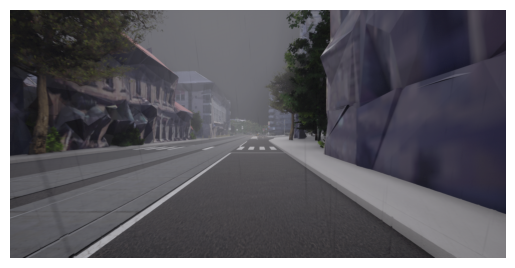

[22 28 22]
1024
2048


In [ ]:

root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_dark_light_decal_dawn_clear/pseudo_color_prediction'
image_path = current_directory + '/0011000280.png'

#/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/instance-segmentation/dashcam/google_dark_light_decal_dawn_rain/instance-segmentation/0129001560.png
image = Image.open('/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/google_dark_light_decal_dawn_rain/rgb/0129001580.png')

plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

image = image.convert("RGB")

# Convert to NumPy array
img_array = np.array(image)
print(img_array[0,0])
print(len(img_array))
print(len(img_array[0]))

## Methods for consufion matrix

### Create method for preprocessing the images


In [ ]:
def read_and_preprocess_image(file_path):
    # Load the image and convert it to grayscale
    image = Image.open(file_path).convert('L')
    # Convert the image to a numpy array
    return np.array(image)

### Create method for creating the confusion matrix with the preprocessed images

In [ ]:
def create_confusion_matrix(true_image, predicted_image):
    # Flatten images and assign each pixel to a class
    true_labels = true_image.flatten()
    predicted_labels = predicted_image.flatten()

    # Calculate confusion matrix
    #confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    return confusion_mat

### Create a method to get the number of classes from a json


In [ ]:
import json

def get_num_classes_from_json(json_file_path):
    # Load JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Find the maximum "id" value
    max_id = max(item['id'] for item in data)

    return max_id

## Methods for reading images

## Method for giving each pixel a label

In [ ]:
color_map_dict = {(label.color): label.category for label in color_map_cityscapes}
color_map_dict_truth = {label.color[0]: label.category for label in color_map_carla}

In [ ]:
def label_for_pixels(pixels):
    #color_map_dict = {(label.color): label.category for label in color_map_cityscapes}

    # Flatten the pixels array to make it easier to iterate over
    flat_pixels = pixels.reshape(-1, pixels.shape[-1])

    # Convert the pixel values to tuples
    pixel_tuples = [tuple(pixel) for pixel in flat_pixels]

    # Create an array of labels based on pixel tuples
    labels = np.array([color_map_dict.get(pixel, None) for pixel in pixel_tuples])

    return labels.reshape(pixels.shape[:-1])


In [ ]:
def label_for_pixels_truth(pixels):
    #color_map_dict = {label.color[0]: label.category for label in color_map_carla}
    rgb_pixels = pixels[:, :, 0]  # Extracting the first channel of each pixel

    # Create a mask array where the keys in color_map_dict are present in rgb_pixels
    mask = np.isin(rgb_pixels, list(color_map_dict_truth.keys()))

    # Use the mask to get the corresponding labels
    labels = np.where(mask, rgb_pixels, None)

    # Map the labels using color_map_dict
    labels = np.vectorize(color_map_dict_truth.get)(labels)

    return labels

## Workbench, read an image and make its confusion matrix (Process time for one rgb image (two img: truth + prediction): 22 sec)

In [ ]:
import cv2

root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
image_current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_dark_light_decal_dawn_clear/pseudo_color_prediction'
prediction_path = image_current_directory + '/0011000300.png'

instance_segmentation_current_directory = root_directory + '/instance_segmentation/dashcam/google_dark_light_decal_dawn_clear/instance_segmentation'
instance_segmentation_path = instance_segmentation_current_directory + '/0011000300.png'




# Read the PNG image
image = cv2.imread(prediction_path, cv2.IMREAD_COLOR)
truth_image = cv2.imread(instance_segmentation_path, cv2.IMREAD_COLOR)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
truth_image_rgb = cv2.cvtColor(truth_image, cv2.COLOR_BGR2RGB)

# Convert the image to a numpy array
image_array = np.array(image_rgb)
truth_image_array = np.array(truth_image_rgb)

labeled_array = label_for_pixels(image_array).flatten()
truth_image_labeled_array =label_for_pixels_truth(truth_image_array).flatten()

matching_elements = sum(1 for x, y in zip(labeled_array, truth_image_labeled_array) if x == y)
total_elements = len(labeled_array)

matching_percentage = (matching_elements / total_elements) * 100




sky
[[ 13 121  66]
 [ 13 121  66]
 [ 13 121  66]
 ...
 [  1 222 124]
 [  1 222 124]
 [  1 222 124]]
87.74514198303223


In [ ]:
def get_matching_percentage(img_name):
  root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
  image_current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_dark_light_decal_day_rain/pseudo_color_prediction'
  prediction_path = image_current_directory + '/' + img_name

  instance_segmentation_current_directory = root_directory + '/instance_segmentation/dashcam/google_dark_light_decal_day_rain/instance_segmentation'
  instance_segmentation_path = instance_segmentation_current_directory + '/' + img_name

  # Read the PNG image
  image = cv2.imread(prediction_path, cv2.IMREAD_COLOR)
  truth_image = cv2.imread(instance_segmentation_path, cv2.IMREAD_COLOR)

  # Convert BGR to RGB
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  truth_image_rgb = cv2.cvtColor(truth_image, cv2.COLOR_BGR2RGB)

  # Convert the image to a numpy array
  image_array = np.array(image_rgb)
  truth_image_array = np.array(truth_image_rgb)

  labeled_array = label_for_pixels(image_array).flatten()
  truth_image_labeled_array =label_for_pixels_truth(truth_image_array).flatten()

  matching_elements = sum(1 for x, y in zip(labeled_array, truth_image_labeled_array) if x == y)
  total_elements = len(labeled_array)

  return (matching_elements / total_elements) * 100

In [ ]:
import os
import json
import cv2

root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
image_current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_dark_light_decal_day_rain/pseudo_color_prediction'
file_names = os.listdir(image_current_directory)
# Filter only PNG files
png_files = [file for file in file_names if file.lower().endswith('.png')]
print(png_files)

percentage_by_img_name = {}

for name in file_names:
  percentage = get_matching_percentage(name)
  percentage_by_img_name[name] = percentage
  with open('/content/drive/MyDrive/Black-Box_CNN/Data/google_dark_light_decal_day_rain.txt', 'a') as file:
    file.write(str(name) + ' ' + str(percentage) + '\n')

with open('/content/drive/MyDrive/Black-Box_CNN/Data/google_dark_light_decal_day_rain.json', 'w') as file:
        json.dump(percentage_by_img_name, file)

['0182000999.png', '0182001000.png', '0182001020.png', '0182001040.png', '0182001560.png', '0184001000.png', '0182001599.png', '0184000999.png', '0182001601.png', '0184001020.png', '0182001600.png', '0182001580.png', '0184001120.png', '0184001099.png', '0184001080.png', '0184001101.png', '0184001100.png', '0184001060.png', '0184001040.png', '0184001199.png', '0184001200.png', '0184001201.png', '0184001220.png', '0184001160.png', '0184001140.png', '0184001180.png', '0184001340.png', '0184001360.png', '0184001280.png', '0184001240.png', '0184001301.png', '0184001320.png', '0184001260.png', '0184001480.png', '0184001401.png', '0184001400.png', '0184001399.png', '0184001460.png', '0184001380.png', '0184001440.png', '0184001420.png', '0184001520.png', '0187000999.png', '0184001580.png', '0184001501.png', '0184001560.png', '0184001599.png', '0184001499.png', '0184001500.png', '0187001000.png', '0187001020.png', '0187001060.png', '0187001099.png', '0187001080.png', '0187001040.png', '01870011

In [ ]:
def get_matching_percentage_DELETE(img_name):
  root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
  image_current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_light_dark_decal_day_clear/pseudo_color_prediction'
  prediction_path = image_current_directory + '/' + img_name

  instance_segmentation_current_directory = root_directory + '/instance_segmentation/dashcam/google_light_dark_decal_day_clear/instance_segmentation'
  instance_segmentation_path = instance_segmentation_current_directory + '/' + img_name

  # Read the PNG image
  image = cv2.imread(prediction_path, cv2.IMREAD_COLOR)
  truth_image = cv2.imread(instance_segmentation_path, cv2.IMREAD_COLOR)

  # Convert BGR to RGB
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  truth_image_rgb = cv2.cvtColor(truth_image, cv2.COLOR_BGR2RGB)

  # Convert the image to a numpy array
  image_array = np.array(image_rgb)
  truth_image_array = np.array(truth_image_rgb)

  labeled_array = label_for_pixels(image_array).flatten()
  truth_image_labeled_array =label_for_pixels_truth(truth_image_array).flatten()

  matching_elements = sum(1 for x, y in zip(labeled_array, truth_image_labeled_array) if x == y)
  total_elements = len(labeled_array)

  return (matching_elements / total_elements) * 100

In [ ]:
import os
import json
import cv2

root_directory = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13'
image_current_directory = root_directory + '/model_output_carla/bisenet/dashcam/google_light_dark_decal_day_clear/pseudo_color_prediction'
file_names = os.listdir(image_current_directory)
# Filter only PNG files
png_files = [file for file in file_names if file.lower().endswith('.png')]
print(png_files)

percentage_by_img_name = {}

for name in file_names:
  percentage = get_matching_percentage_DELETE(name)
  percentage_by_img_name[name] = percentage
  with open('/content/drive/MyDrive/Black-Box_CNN/Data/google_light_dark_decal_day_clear.txt', 'a') as file:
    file.write(str(name) + ' ' + str(percentage) + '\n')

with open('/content/drive/MyDrive/Black-Box_CNN/Data/google_light_dark_decal_day_clear.json', 'w') as file:
        json.dump(percentage_by_img_name, file)

['0538003300.png', '0538003280.png', '0538003299.png', '0538003380.png', '0538003399.png', '0538003301.png', '0538003400.png', '0538003360.png', '0538003340.png', '0538003320.png', '0538003500.png', '0538003499.png', '0538003480.png', '0538003460.png', '0538003440.png', '0538003420.png', '0538003501.png', '0538003401.png', '0538003520.png', '0540003680.png', '0538003540.png', '0541003280.png', '0541003299.png', '0538003560.png', '0540003660.png', '0541003320.png', '0541003399.png', '0541003360.png', '0541003380.png', '0541003301.png', '0541003300.png', '0541003340.png', '0541003460.png', '0541003420.png', '0541003440.png', '0541003401.png', '0541003480.png', '0541003499.png', '0541003400.png', '0541003500.png', '0541003620.png', '0541003520.png', '0541003540.png', '0541003501.png', '0541003560.png', '0541003580.png', '0547003280.png', '0541003640.png', '0541003680.png', '0547003300.png', '0547003301.png', '0547003299.png', '0541003660.png', '0547003400.png', '0547003380.png', '05470033

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


##Highest accuracy image

97.15523719787598


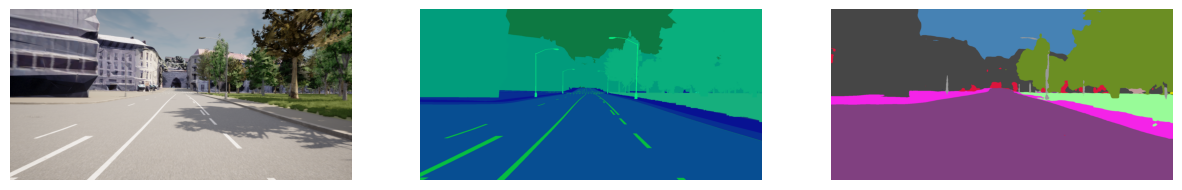

In [ ]:
txt_root_dir = '/content/drive/MyDrive/Black-Box_CNN/Data/percentages_txt'
file_names = os.listdir(txt_root_dir)
txt_files = [file for file in file_names if file.lower().endswith('.txt')]
num_of_mispredictions = 0
mispredictions = {}
max_percentage = 0
max_accuracy_path = ""
for name in file_names:
  with open(txt_root_dir + '/' + name, 'r') as file:
    for line in file:
        parts = line.split()
        if len(parts) == 2:
            filename, value = parts
            value = float(value)
            edited_name = name.replace('.txt', '')
            img_path = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/' + edited_name + '/rgb/' + str(filename)
            if value > max_percentage:
              max_percentage = value
              max_accuracy_path = img_path
path_parts = max_accuracy_path.split('/')
google_folder_name = path_parts[-3]
print(max_percentage)
png_name = path_parts[-1]
images = [
   max_accuracy_path,
   '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/instance_segmentation/dashcam/' + google_folder_name + '/instance_segmentation/' + png_name,
   '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/model_output_carla/bisenet/dashcam/' + google_folder_name + '/pseudo_color_prediction/' + png_name
]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, current_img_path in enumerate(images):
    image = Image.open(current_img_path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis
plt.show()

## Number of predictions with less than 70% (Store their path in a file)



In [ ]:
txt_root_dir = '/content/drive/MyDrive/Black-Box_CNN/Data/percentages_txt'
file_names = os.listdir(txt_root_dir)
txt_files = [file for file in file_names if file.lower().endswith('.txt')]
num_of_mispredictions = 0
mispredictions = {}
for name in file_names:
  with open(txt_root_dir + '/' + name, 'r') as file:
    for line in file:
        parts = line.split()
        if len(parts) == 2:
            filename, value = parts
            value = float(value)
            edited_name = name.replace('.txt', '')
            img_path = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/' + edited_name + '/rgb/' + str(filename)
            if value < 70:
              mispredictions[img_path] = value
with open('/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt', 'w') as file:
    for key, value in mispredictions.items():
        file.write(f"{key} {value}\n")
print(len(mispredictions))

539


## Convert predicted image to ground truth colors

In [ ]:
def create_color_map_dict(color_map):
    return {tuple(label[-1]): label[-2] for label in color_map}

def create_reverse_color_map_dict(color_map):
    return {label[-2]: tuple(label[-1]) for label in color_map}

In [ ]:
def convert_prediction_to_ground_truth_colors(prediction_image):
    # Load prediction image
    pred_img = cv2.imread(prediction_image)

    # Create color maps
    color_map_from_dict = {tuple(label[-1]): label[-2] for label in color_map_carla}
    color_map_to_dict = {label[-2]: tuple(label[-1]) for label in color_map_cityscapes}
    print(color_map_from_dict)
    print(color_map_to_dict)

    # Create an output array
    output_array = np.zeros_like(pred_img)

    # Map each color in the prediction to the corresponding ground truth color
    for from_color, class_id in color_map_from_dict.items():
        if class_id in color_map_to_dict:
            to_color = color_map_to_dict[class_id]
            mask = np.all(pred_img == np.array(from_color), axis=-1)
            output_array[mask] = to_color

    return output_array

{(0, 0, 0): True, (1, 0, 0): False, (2, 0, 0): False, (3, 0, 0): True, (4, 0, 0): False, (5, 0, 0): False, (6, 0, 0): False, (7, 0, 0): False, (8, 0, 0): False, (9, 0, 0): False, (10, 0, 0): False, (11, 0, 0): False, (12, 0, 0): False, (13, 0, 0): False, (14, 0, 0): True, (15, 0, 0): True, (16, 0, 0): True, (17, 0, 0): True, (18, 0, 0): False, (19, 0, 0): False, (20, 0, 0): True, (21, 0, 0): True, (22, 0, 0): False}
{True: (0, 0, 142), False: (119, 11, 32)}


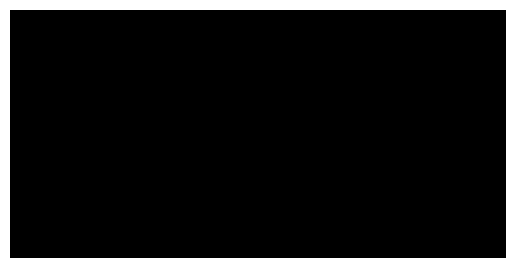

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
path = '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/model_output_carla/bisenet/dashcam/google_dark_light_decal_dawn_clear/pseudo_color_prediction/0011000280.png'
converted_image = convert_prediction_to_ground_truth_colors(path)
plt.imshow(converted_image)
plt.axis('off')  # Turn off axis labels
plt.show()

## Print some mispredicted images

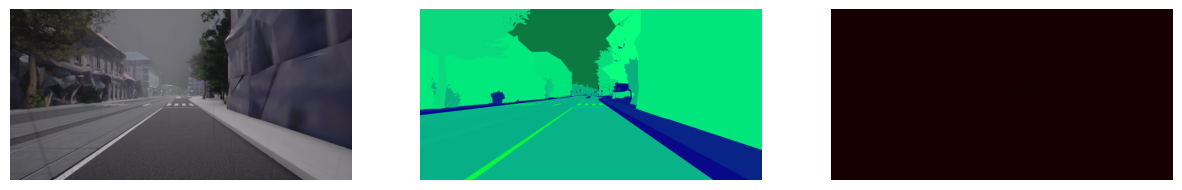

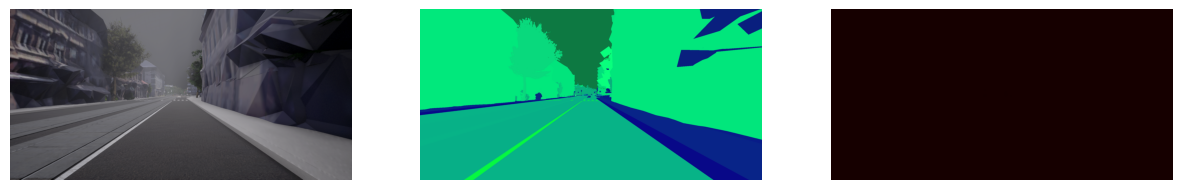

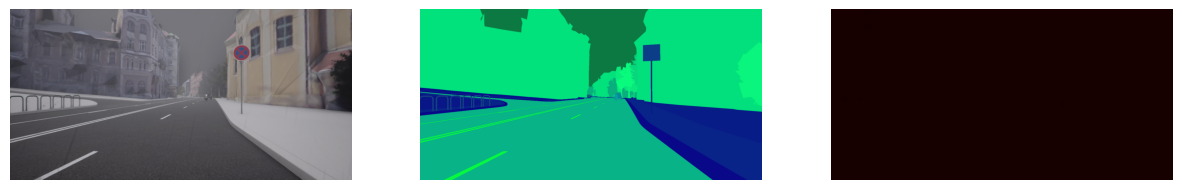

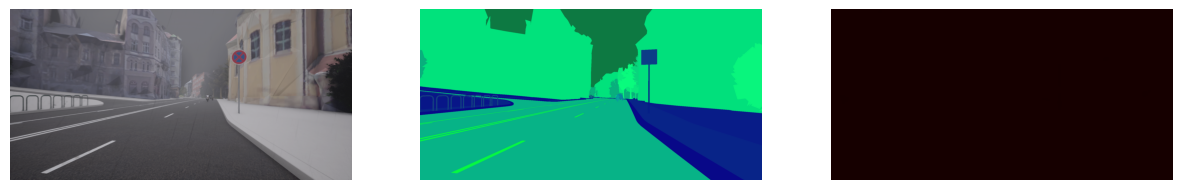

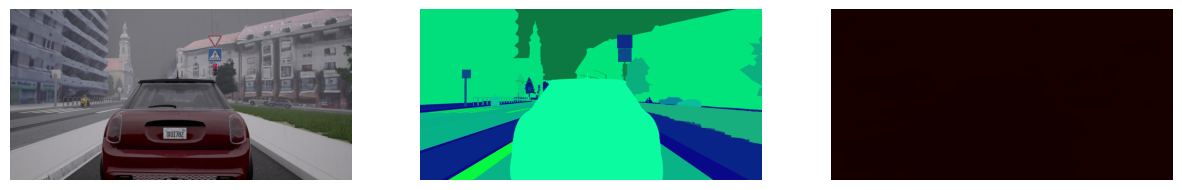

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path
file_path = '/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt'

# Open the file
with open(file_path, 'r') as file:
    line_count = 0
    for line in file:
        # Split the line
        parts = line.split()
        if len(parts) == 2:
            filename, value = parts
            path_parts = filename.split('/')
            google_folder_name = path_parts[-3]
            png_name = path_parts[-1]
            value = float(value)
            images = [
                filename,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/instance_segmentation/dashcam/' + google_folder_name + '/instance_segmentation/' + png_name,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/model_output_carla/bisenet/dashcam/' + google_folder_name + '/pseudo_color_prediction/' + png_name
            ]
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i, current_img_path in enumerate(images):
                image = Image.open(current_img_path)
                if(i == 2):
                  image = convert_prediction_to_ground_truth_colors(current_img_path)
                axes[i].imshow(image)
                axes[i].axis('off')  # Turn off axis
            plt.show()
            line_count += 1
            if line_count == 5:
                break


In [ ]:
from keras.applications import VGG16

conv_base = VGG16(include_top=False, pooling='avg')
conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

## Preprocess img (1024x2048 --> 224x224)

In [ ]:
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path):
    # Read image using OpenCV
    image = cv2.imread(image_path)

    # Resize image to match VGG16 input size (224x224)
    image = cv2.resize(image, (224, 224))

    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to float32
    image = image.astype("float32")

    # Apply VGG16 preprocessing
    image = preprocess_input(image)

    return image

## Display 224x224x3 images

In [ ]:
import matplotlib.pyplot as plt

def display_image(image_array):
    # Convert image from float32 to uint8
    image_array = (image_array * 255).astype('uint8')

    # Display image
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()


### example

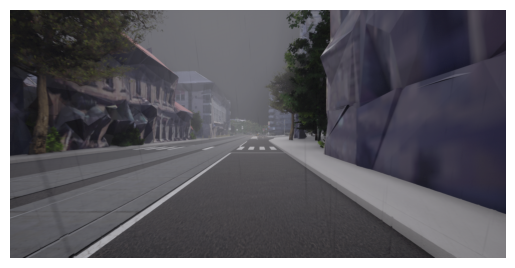

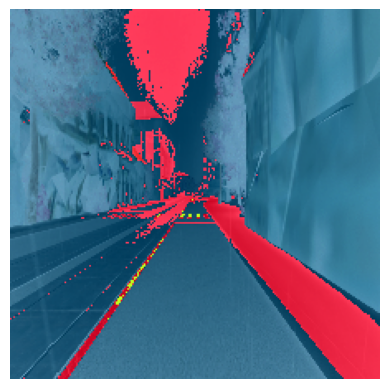

In [ ]:
image = Image.open('/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/google_dark_light_decal_dawn_rain/rgb/0129001580.png')
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()
img_array = preprocess_image('/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/google_dark_light_decal_dawn_rain/rgb/0129001580.png')
display_image(img_array)

## Resize mispredicted images and store them in npy


In [ ]:
# Define the file path
file_path = '/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt'
preprocessed_images = []
# Open the file
with open(file_path, 'r') as file:
  for line in file:
    parts = line.split()
    if len(parts) == 2:
      rgb_path, value = parts
      preprocessed_images.append(preprocess_image(rgb_path))

print(len(preprocessed_images))
preprocessed_images_array = np.array(preprocessed_images)

# Save the array to a file
np.save("/content/drive/MyDrive/Black-Box_CNN/Data/preprocessed_images/preprocessed_images.npy", preprocessed_images_array)

539


## extract feature vectors

In [ ]:
file_path = "/content/drive/MyDrive/Black-Box_CNN/Data/preprocessed_images/preprocessed_images.npy"
preprocessed_images = np.load(file_path)

feature_vectors = []
batch_size= 32
num_images = len(preprocessed_images)

for i in range(0, num_images, batch_size):
    print(i)
    start_index = i
    end_index = min(i + batch_size, num_images)

    preprocessed_batch_images = preprocessed_images[start_index:end_index]
    batch_vectors = conv_base.predict(preprocessed_batch_images)

    feature_vectors.append(batch_vectors)

feature_vectors_arr = np.concatenate(feature_vectors, axis=0)
np.save('/content/drive/MyDrive/Black-Box_CNN/Data/feature_vectors/dashcam_google_feature_vectors.npy', feature_vectors_arr)

0
1/1 [==============================] - 14s 14s/step
32
1/1 [==============================] - 13s 13s/step
64
1/1 [==============================] - 13s 13s/step
96
1/1 [==============================] - 13s 13s/step
128
1/1 [==============================] - 12s 12s/step
160
1/1 [==============================] - 12s 12s/step
192
1/1 [==============================] - 13s 13s/step
224
1/1 [==============================] - 12s 12s/step
256
1/1 [==============================] - 12s 12s/step
288
1/1 [==============================] - 12s 12s/step
320
1/1 [==============================] - 12s 12s/step
352
1/1 [==============================] - 13s 13s/step
384
1/1 [==============================] - 13s 13s/step
416
1/1 [==============================] - 12s 12s/step
448
1/1 [==============================] - 13s 13s/step
480
1/1 [==============================] - 12s 12s/step
512
1/1 [==============================] - 11s 11s/step


## Clustering (in high dim)


In [ ]:
!pip install umap-learn
import umap.umap_ as umap

from sklearn.preprocessing import StandardScaler

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Black-Box_CNN/Data/feature_vectors/dashcam_google_feature_vectors.npy')

# Apply UMAP
fit = umap.UMAP(n_neighbors=10, min_dist=0.03, n_components=300)
partly_reduced_vectors = fit.fit_transform(feature_vectors)
fit = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=250)
reduced_vectors = fit.fit_transform(partly_reduced_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/umap_250_google_dashcam_images.npy', reduced_vectors)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00


##HDBSCAN (result: 48 clusters)


Number of clusters: 50


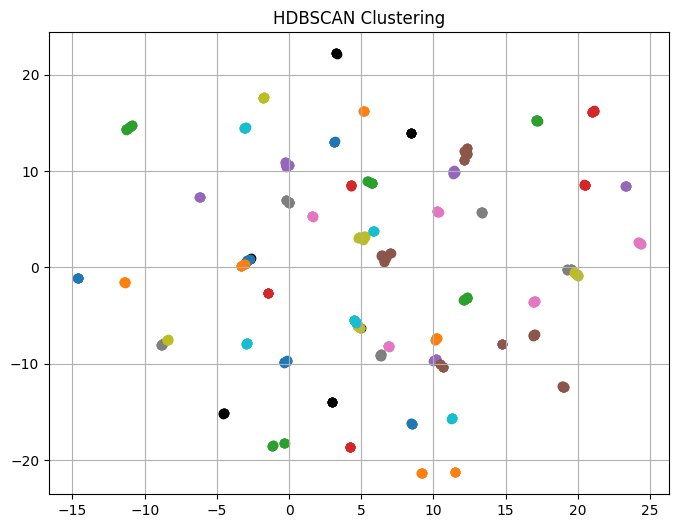

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install hdbscan
import hdbscan
import umap

# Load the feature vectors
feature_vectors_250 = np.load('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/umap_250_google_dashcam_images.npy')

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
feature_vectors_2d = umap_model.fit_transform(feature_vectors_250)

# Create an HDBSCAN instance
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5)

# Fit the HDBSCAN model to your 2D data
hdbscan_labels = hdbscan_model.fit_predict(feature_vectors_2d)

# Get the number of clusters (-1 indicates outliers)
num_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print("Number of clusters:", num_clusters)

# Scatter plot the points colored by cluster labels
plt.figure(figsize=(8, 6))
cluster_indices = [[] for _ in range(num_clusters)]
for label in range(-1, num_clusters):
    if label == -1:
        # Outliers
        plt.scatter(feature_vectors_2d[hdbscan_labels == label][:, 0],
                    feature_vectors_2d[hdbscan_labels == label][:, 1],
                    color='black', marker='o', label='Outliers')
    else:
        # Clustered points
        cluster_points = feature_vectors_2d[hdbscan_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
        # Get indices of samples from each cluster
        cluster_indices[label] = np.where(hdbscan_labels == label)[0].tolist()

plt.title('HDBSCAN Clustering')
plt.grid(True)
plt.show()

cluster_indices = [cluster for cluster in cluster_indices if cluster]

# Convert to NumPy array
cluster_indices = np.array(cluster_indices)

# Save cluster indices
np.save('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/cluster_indices_of_all_samples.npy', cluster_indices)


In [ ]:
print(cluster_indices)
np.save('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/cluster_indices_of_all_samples.npy', cluster_indices)

[[88, 89, 90, 91, 92, 93, 94], [141, 145, 148, 149, 150, 151, 153, 154], [65, 66, 109, 114, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224], [56, 57, 58, 59, 60, 61, 62, 87, 340, 538], [229, 231, 232, 240, 241, 242], [341, 342, 343, 344, 347, 348, 349, 350, 351, 352, 355], [293, 295, 298, 301, 305, 306, 308, 309, 367, 368, 369], [10, 196, 198, 200, 201, 203, 208, 282, 531], [190, 191, 204, 205, 206, 207, 434], [2, 3, 63, 260, 261, 262, 280, 519], [30, 31, 34, 35, 36, 40, 46, 47, 49, 51, 52, 236], [345, 346, 353, 354, 356, 358, 440, 441, 442, 496, 497], [209, 448, 449, 450, 451, 452, 453, 454, 455, 456, 460, 465, 466], [391, 392, 393, 394, 395, 396, 397], [127, 130, 131, 132, 134, 365], [1, 77, 78, 80, 84, 115, 239, 366, 399, 521, 523, 524, 525, 526, 530], [498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 510], [233, 234, 235, 237, 436, 438, 439, 443], [15, 16, 17, 18, 81, 263, 265, 272, 273, 283, 285, 288, 290, 492, 493, 494, 495, 520], [116, 117, 118, 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.

## Display cluster samples

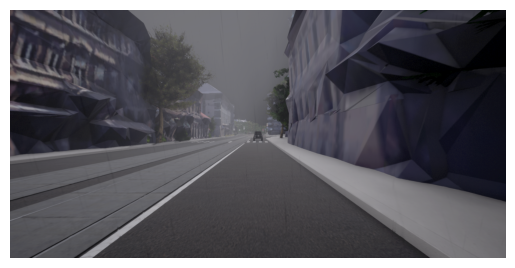

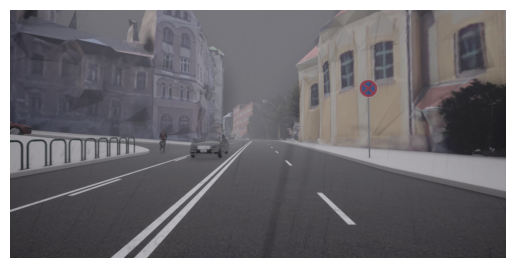

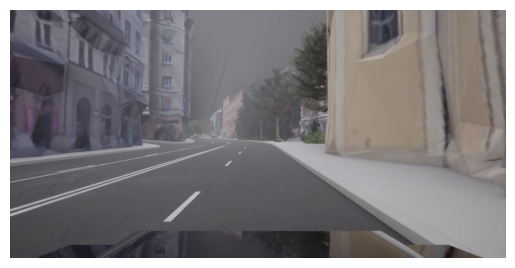

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cluster_indices = np.load('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/cluster_indices_of_samples.npy')

# Define the file path
file_path = '/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt'

lines = []
# Open the file
with open(file_path, 'r') as file:
  for line in file:
    parts = line.split()
    if len(parts) == 2:
      lines.append(parts[0])



for i in range(0, 3):
    idx = cluster_indices[4][i]
    image = Image.open(lines[idx])
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    print("\n\n")

In [ ]:
cluster_indexes = [[88, 89, 90, 91, 92, 93, 94], [141, 145, 148, 149, 150, 151, 153, 154], [65, 66, 109, 114, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224], [56, 57, 58, 59, 60, 61, 62, 87, 340, 538], [229, 231, 232, 240, 241, 242], [341, 342, 343, 344, 347, 348, 349, 350, 351, 352, 355], [293, 295, 298, 301, 305, 306, 308, 309, 367, 368, 369], [10, 196, 198, 200, 201, 203, 208, 282, 531], [190, 191, 204, 205, 206, 207, 434], [2, 3, 63, 260, 261, 262, 280, 519], [30, 31, 34, 35, 36, 40, 46, 47, 49, 51, 52, 236], [345, 346, 353, 354, 356, 358, 440, 441, 442, 496, 497], [209, 448, 449, 450, 451, 452, 453, 454, 455, 456, 460, 465, 466], [391, 392, 393, 394, 395, 396, 397], [127, 130, 131, 132, 134, 365], [1, 77, 78, 80, 84, 115, 239, 366, 399, 521, 523, 524, 525, 526, 530], [498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 510], [233, 234, 235, 237, 436, 438, 439, 443], [15, 16, 17, 18, 81, 263, 265, 272, 273, 283, 285, 288, 290, 492, 493, 494, 495, 520], [116, 117, 118, 119, 120, 121], [123, 128, 129, 133, 136, 138], [180, 182, 183, 184, 185, 186, 187, 188, 192], [96, 398, 515, 516, 517, 518, 522, 532, 535, 536], [296, 297, 299, 300, 302, 303, 304, 307, 310, 311, 312], [54, 55, 69, 70, 72, 75, 76, 294, 432, 444, 488], [82, 101, 102, 103, 104, 105, 106, 107, 435], [135, 137, 139, 140, 142, 143, 144, 146, 147], [372, 373, 374, 376, 377, 378, 380, 381, 537], [21, 22, 23, 264, 266, 268, 270, 271], [328, 330, 331, 332, 333, 334, 335, 336, 337], [225, 245, 248, 249, 250, 251, 252, 255], [64, 226, 243, 244, 246, 247, 253, 254, 257, 259, 269], [68, 85, 122, 124, 152, 159, 258, 527, 528, 529, 533, 534], [83, 274, 275, 276, 277, 338, 339], [278, 279, 281, 284, 315, 316, 370, 371, 382, 383, 385, 388, 445, 447], [95, 97, 98, 99, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 419, 421, 422, 423, 424, 425, 426, 429, 431, 437, 489], [319, 320, 322, 323, 324, 325, 326, 327, 329], [457, 458, 459, 461, 462, 463, 464], [467, 468, 471, 474, 477, 478, 480, 481, 485, 486, 487], [469, 472, 473, 476, 479, 482, 483, 484, 490], [25, 26, 27, 28, 29, 230], [176, 177, 178, 179, 406, 433], [314, 357, 359, 360, 362, 379, 387, 389, 390, 401], [313, 317, 321, 361, 363, 364, 400], [0, 19, 20, 24, 79, 100, 181, 238, 267, 384, 386, 402, 403, 404, 405, 446], [11, 12, 13, 14, 67, 71, 73, 74, 155, 156, 157, 189, 193, 194, 195, 197, 199, 202, 318, 407], [4, 5, 6, 7, 8, 9], [32, 33, 37, 38, 39, 41, 42, 43, 44, 45, 48, 50, 53], [125, 126, 158, 160, 162, 163, 164, 169, 170, 171, 172, 173, 174, 175], [161, 165, 166, 167, 168, 375]]

## All images by clusters

NameError: name 'i' is not defined

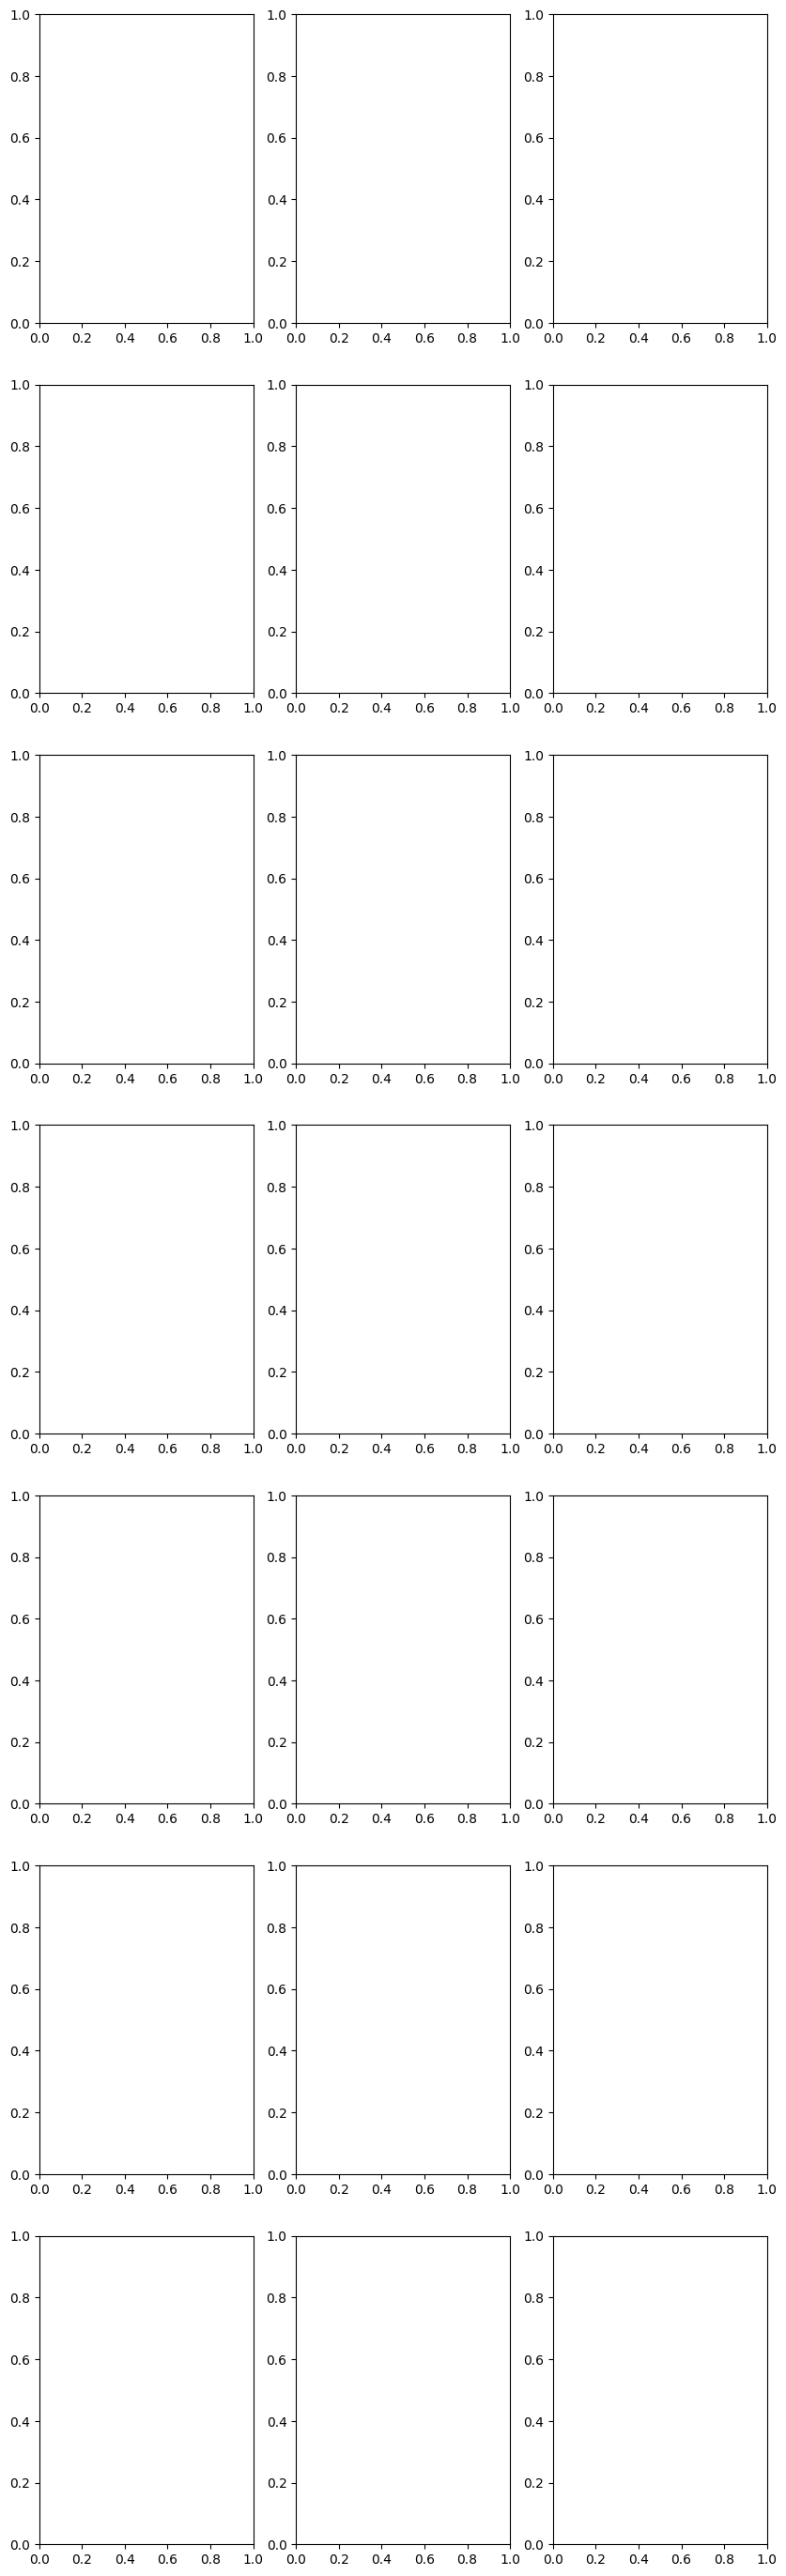

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

image_counter = 0
cluster_indexes = cluster_indexes[image_counter:]
# Define the file path
file_path = '/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt'

images = []
# Open the file
with open(file_path, 'r') as file:
    line_count = 0
    for line in file:
        # Split the line
        parts = line.split()
        if len(parts) == 2:
            filename, value = parts
            path_parts = filename.split('/')
            google_folder_name = path_parts[-3]
            png_name = path_parts[-1]
            value = float(value)
            images.append([
                filename,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/instance_segmentation/dashcam/' + google_folder_name + '/instance_segmentation/' + png_name,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/model_output_carla/bisenet/dashcam/' + google_folder_name + '/pseudo_color_prediction/' + png_name
           ] )

all_images = []
all_ground_truth_images =  []
all_model_output_images =  []
# Load all images
for three_image in images:
    all_images.append(np.array(Image.open(three_image[0])))
    all_ground_truth_images.append(np.array(Image.open(three_image[1])))
    all_model_output_images.append(np.array(Image.open(three_image[2])))

# Iterate through each cluster
for cluster_num, indices in enumerate(cluster_indexes):
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5*num_images))
    fig.suptitle(f'Cluster {cluster_num+i}', fontsize=16)

    for i, idx in enumerate(indices):
        axes[i, 0].imshow(all_images[idx])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')



        axes[i, 1].imshow(all_ground_truth_images[idx])
        axes[i, 1].set_title('Ground Truth Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(all_model_output_images[idx])
        axes[i, 2].set_title('Model Output Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'/content/drive/MyDrive/Black-Box_CNN/Data/clusters/images/cluster_{image_counter+i}_images.png')
    plt.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from joblib import Parallel, delayed

# Load cluster indices
#cluster_indices = np.load('/content/drive/MyDrive/Black-Box_CNN/Data/clusters/cluster_indices_of_all_samples.npy', allow_pickle=True)

# Take only the first 5 clusters
cluster_indexes = cluster_indexes[0:]

# Define the file path
file_path = '/content/drive/MyDrive/Black-Box_CNN/Data/mispredictions/below_70/dashcam_google_images_mispredictions.txt'

images = []
# Open the file
with open(file_path, 'r') as file:
    line_count = 0
    for line in file:
        # Split the line
        parts = line.split()
        if len(parts) == 2:
            filename, value = parts
            path_parts = filename.split('/')
            google_folder_name = path_parts[-3]
            png_name = path_parts[-1]
            value = float(value)
            images.append([
                filename,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/instance_segmentation/dashcam/' + google_folder_name + '/instance_segmentation/' + png_name,
                '/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/model_output_carla/bisenet/dashcam/' + google_folder_name + '/pseudo_color_prediction/' + png_name
           ] )

def load_image(image_path):
    return np.array(Image.open(image_path))

def load_images(image_paths):
    return [load_image(image_path) for image_path in image_paths]

# Iterate through each cluster
for cluster_num, indices in enumerate(cluster_indexes):
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5*num_images))
    fig.suptitle(f'Cluster {cluster_num}', fontsize=16)

    # Load all images in parallel
    all_images = Parallel(n_jobs=-1)(delayed(load_images)([images[idx][0]]) for idx in indices)
    all_model_output_images = Parallel(n_jobs=-1)(delayed(load_images)([images[idx][2]]) for idx in indices)
    all_ground_truth_images = Parallel(n_jobs=-1)(delayed(load_images)([images[idx][1]]) for idx in indices)

    for i, (image, model_output, ground_truth) in enumerate(zip(all_images, all_model_output_images, all_ground_truth_images)):
        axes[i, 0].imshow(image[0])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(model_output[0])
        axes[i, 1].set_title('Model Output Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(ground_truth[0])
        axes[i, 2].set_title('Ground Truth Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'/content/drive/MyDrive/Black-Box_CNN/Data/clusters/images/cluster_{cluster_num}_images.png')
    plt.close()


In [ ]:
for cluster_num, indices in enumerate(cluster_indices):
    print("cluster num: " + str(cluster_num) + " indices: "+ str(indices) +"\n")
    for i, idx in enumerate(indices):
      print("i: " + str(i) + " idx: " + str(idx) +"\n\n")

cluster num: 0 indices: [88, 89, 90, 91, 92, 93, 94]

i: 0 idx: 88


i: 1 idx: 89


i: 2 idx: 90


i: 3 idx: 91


i: 4 idx: 92


i: 5 idx: 93


i: 6 idx: 94


cluster num: 1 indices: [141, 145, 148, 149, 150, 151, 153, 154]

i: 0 idx: 141


i: 1 idx: 145


i: 2 idx: 148


i: 3 idx: 149


i: 4 idx: 150


i: 5 idx: 151


i: 6 idx: 153


i: 7 idx: 154


cluster num: 2 indices: [65, 66, 109, 114, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]

i: 0 idx: 65


i: 1 idx: 66


i: 2 idx: 109


i: 3 idx: 114


i: 4 idx: 210


i: 5 idx: 211


i: 6 idx: 212


i: 7 idx: 213


i: 8 idx: 214


i: 9 idx: 215


i: 10 idx: 216


i: 11 idx: 217


i: 12 idx: 218


i: 13 idx: 219


i: 14 idx: 220


i: 15 idx: 221


i: 16 idx: 222


i: 17 idx: 223


i: 18 idx: 224


cluster num: 3 indices: [56, 57, 58, 59, 60, 61, 62, 87, 340, 538]

i: 0 idx: 56


i: 1 idx: 57


i: 2 idx: 58


i: 3 idx: 59


i: 4 idx: 60


i: 5 idx: 61


i: 6 idx: 62


i: 7 idx: 87


i: 8 idx: 340


i: 9 idx: 538

In [ ]:
print(all_images[88])

/content/drive/MyDrive/Black-Box_CNN/Data/dataset-2022-10-13/rgb/dashcam/google_dark_light_decal_day_clear/rgb/0271002020.png
